<a href="https://colab.research.google.com/github/CryptoRobotFr/pair_trading/blob/main/pair_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ccxt statsmodels ta

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.float_format = '{:.6f}'.format
import ccxt
import matplotlib.pyplot as plt
import ta
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from statsmodels.tsa.stattools import coint


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def get_ohlcv(symbol, tf):
    df = pd.DataFrame(exchange.fetch_ohlcv(symbol, tf, limit=5000))
    df = df.rename(columns={0: 'timestamp', 1: 'open', 2: 'high', 3: 'low', 4: 'close', 5: 'volume'})
    df = df.set_index(df['timestamp'])
    df.index = pd.to_datetime(df.index, unit='ms')
    del df['timestamp']
    return df

exchange = ccxt.ftx()
markets = exchange.load_markets()
symbols = exchange.symbols
df_list = {}

def custom_filter(symbol):
    if(
        symbol[-4:] == "/USD"
        and "BULL" not in symbol
        and "HALF" not in symbol
        and "EDGE" not in symbol
        and "BEAR" not in symbol
    ):
	    return True

symbols = list(filter(custom_filter, symbols))

for symbol in symbols:
    ohlcv = get_ohlcv(symbol, "1h")
    if ohlcv["volume"].mean() > 10000:
        df_list[symbol] = ohlcv

In [ ]:
df_list_origin = df_list.copy()
for symbol in df_list_origin:
    if len(df_list[symbol]) < 5000:
        del df_list[symbol]

In [ ]:
full_df = pd.DataFrame()
for symbol in df_list:
    full_df[symbol] = df_list[symbol]['close']
cumret = np.log(full_df).diff().cumsum()+1 # calculate cumulative returns
cumret.dropna(inplace=True) 
cumret

,1INCH/USD,AAVE/USD,ALCX/USD,ALPHA/USD,AMPL/USD,AUDIO/USD,AXS/USD,BADGER/USD,BAND/USD,BAO/USD,BAT/USD,BCH/USD,BNB/USD,BNT/USD,BRZ/USD,BTC/USD,C98/USD,CEL/USD,CHR/USD,CHZ/USD,COMP/USD,CONV/USD,COPE/USD,CQT/USD,CREAM/USD,CRO/USD,CRV/USD,DAI/USD,DOGE/USD,ENJ/USD,ETH/USD,ETHE/USD,EUR/USD,FIDA/USD,FTM/USD,FTT/USD,GBP/USD,GBTC/USD,GRT/USD,HNT/USD,...,MATIC/USD,MEDIA/USD,MER/USD,MKR/USD,MOB/USD,OKB/USD,OMG/USD,OXY/USD,PAXG/USD,PERP/USD,RAY/USD,REN/USD,ROOK/USD,RSR/USD,RUNE/USD,SAND/USD,SECO/USD,SHIB/USD,SKL/USD,SLP/USD,SLRS/USD,SNX/USD,SOL/USD,SRM/USD,STEP/USD,STORJ/USD,SUN/USD,SUSHI/USD,SXP/USD,TOMO/USD,TRU/USD,TRX/USD,TRYB/USD,TSLA/USD,UNI/USD,USDT/USD,WBTC/USD,XRP/USD,YFI/USD,ZRX/USD
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-08-01 14:00:00,0.996616,1.001475,1.002167,1.002782,1.006791,0.998264,1.000658,1.000443,0.991988,1.000000,0.999557,1.004900,1.003681,1.001684,0.999267,0.998309,0.996620,0.993977,0.997772,0.997857,1.000597,0.999596,0.954694,0.996525,1.002053,0.995521,1.003831,1.000000,0.998839,0.993571,1.000891,1.000000,0.998988,1.000125,0.999806,1.000314,1.000000,0.997642,1.006934,1.003296,...,0.996110,1.000000,0.997469,0.997155,1.000048,1.007065,0.998774,0.997068,1.000000,0.982617,0.998282,1.004059,1.001286,0.995752,1.015957,0.994999,1.002962,0.996880,1.002321,0.982311,0.988692,1.002017,1.008091,0.994187,0.994565,0.999084,0.993561,1.002419,0.996588,1.002238,0.998290,1.001720,0.999749,1.000000,1.006701,1.000000,0.998213,0.998145,0.997402,1.002433
2021-08-01 15:00:00,0.996323,0.999477,1.047395,0.998928,1.004626,0.990394,1.005123,1.001328,0.992452,1.000305,1.006914,1.004763,1.001993,1.002525,0.999214,0.997341,1.029920,0.993324,0.994422,0.996118,0.999552,0.999596,0.922189,1.008520,1.008443,0.995521,0.999680,1.000000,1.000599,0.992838,1.001472,1.000000,0.998398,1.006658,1.016136,1.000743,1.000000,0.995974,1.007788,1.001559,...,0.994281,1.000000,0.997239,0.995813,1.000048,1.006455,1.001002,1.000512,1.000055,0.985500,0.999680,1.001129,1.008328,0.994536,0.993716,0.974575,1.005722,1.000000,0.989879,0.991254,0.996051,1.003023,1.011408,0.999244,0.994565,0.992647,1.003816,0.999501,0.989041,0.993602,0.991889,1.000765,1.001923,1.002304,1.005810,1.000000,0.997221,1.002215,0.998625,0.995116
2021-08-01 16:00:00,0.989435,0.992745,1.038303,0.992040,0.988770,0.988727,0.992840,1.005743,0.983911,0.994792,0.990284,1.008365,0.998388,1.001404,0.998952,0.996130,1.002359,0.990707,0.969501,0.991855,0.992858,0.985366,0.916714,0.966370,0.989150,0.994350,0.999011,0.999900,0.997219,0.986784,0.996077,1.000000,1.000084,0.996079,1.006947,0.996391,1.000000,0.995556,0.993379,0.983214,...,0.994002,1.000000,0.996317,0.987895,0.987567,1.003602,0.992621,0.996334,0.998791,0.982405,0.988998,0.995357,0.993546,0.980742,1.005091,0.964538,1.000670,0.993750,0.983600,0.982431,0.983442,1.000757,1.003983,0.993172,0.994565,0.990338,1.018508,0.994293,0.980974,0.986193,0.982447,0.992511,1.001171,1.000000,1.008613,1.000100,0.995938,1.003765,0.990492,0.985894
2021-08-01 17:00:00,0.986184,0.985625,1.059731,0.984306,0.995542,0.988257,0.983033,0.989757,0.979534,0.992332,0.984717,0.998760,0.993566,0.996764,0.998952,0.992148,1.012326,0.991116,0.966876,0.985885,0.988085,0.985775,0.922329,0.970189,0.981327,0.990827,0.991208,0.999900,0.992315,0.984464,0.996505,1.000000,1.000000,0.991053,1.006370,0.993114,1.000000,0.991652,0.990486,0.973854,...,0.987563,0.994751,0.995163,0.985863,0.987713,1.005844,0.994975,0.997068,0.998791,0.976684,0.985048,0.998077,0.992251,0.968788,0.992860,0.954146,0.989000,0.990610,0.983206,0.986614,0.983285,0.991689,1.001353,0.974734,1.005405,0.983379,1.009503,0.992309,0.972374,0.984818,0.977852,0.989770,1.001171,1.000000,1.003803,1.000000,0.989985,0.995456,0.988487,0.985894
2021-08-01 18:00:00,0.997118,0.994386,1.131903,1.007117,0.997916,0.983151,1.007285,0.992439,0.998157,0.999083,1.001070,1.001055,0.994461,1.002245,0.998952,0.991661,1.004629,0.993814,0.984625,0.990743,0.999477,0.992303,0.954830,0.960372,0.985246

In [ ]:
pre_select_obj = {}
for col in list(cumret.columns.values):
    pre_select_obj[col] = {
        "return": cumret[col].iloc[-1] - cumret[col].iloc[0],
        # "return": cumret[col].diff().mean(),
        "std": cumret[col].std()
    }

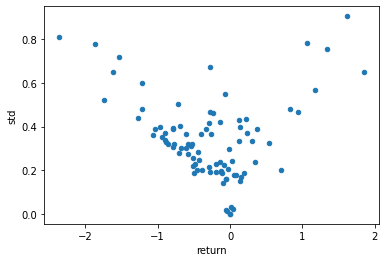

In [ ]:
df_pre_select = pd.DataFrame.from_dict(pre_select_obj, orient='index')
df_pre_select.plot.scatter(x='return', y='std')

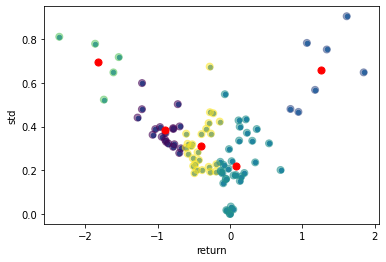

In [ ]:
df_pre_select = pd.DataFrame.from_dict(pre_select_obj, orient='index')
df_pre_select.plot.scatter(x='return', y='std')
  
kmeans = KMeans(n_clusters=5).fit(df_pre_select)
centroids = kmeans.cluster_centers_
# print(centroids)

cluster_map = pd.DataFrame()
cluster_map['data_index'] = df_pre_select.index.values
cluster_map['cluster'] = kmeans.labels_

plt.scatter(df_pre_select['return'], df_pre_select['std'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

In [ ]:
train_cumret = cumret.copy().iloc[:3500] # formation period
test_cumret = cumret.copy().iloc[-1500:] # trading period

get_sub_cluster = 1

df_train = train_cumret.copy()[list(cluster_map[cluster_map.cluster == get_sub_cluster]["data_index"])]
df_test = test_cumret.copy()[list(cluster_map[cluster_map.cluster == get_sub_cluster]["data_index"])]
df_train.columns.values

array(['CRO/USD', 'FTM/USD', 'HUM/USD', 'LRC/USD', 'SAND/USD', 'SHIB/USD',
       'SOL/USD'], dtype=object)

In [ ]:
train = df_train.copy()
tested = []
metrics_obj = {}

for s1 in train.columns:
    for s2 in train.columns:
        if s1!=s2 and (f'{s1}-{s2}' not in tested) and (f'{s2}-{s1}' not in tested):
                tested.append(f'{s1}-{s2}')
                cadf_p = coint(train[s1], train[s2])[1]
                spread_window = 25
                spread = np.log10(train[s1] / train[s1].shift(periods=spread_window)) - np.log10(train[s2] / train[s2].shift(periods=spread_window))
                spread = spread.fillna(0)
                std_spread = spread.std()
                correlation = train[s1].corr(train[s2])
                metrics_obj[f'{s1}-{s2}'] = {
                    "co-int": cadf_p,
                    "std_spread": std_spread,
                    "correlation": correlation
                }


In [ ]:
pd.options.display.float_format = '{:.6f}'.format
df_metrics = pd.DataFrame.from_dict(metrics_obj, orient='index')
df_metrics["rating"] = (1 - df_metrics["co-int"]) + df_metrics["correlation"] + 10*df_metrics["std_spread"]
df_metrics.sort_values(by="rating", ascending=False).iloc[:30]

,co-int,std_spread,correlation,rating
CRO/USD-SAND/USD,0.008930,0.023891,0.974434,2.204417
CRO/USD-LRC/USD,0.175098,0.022142,0.955700,2.002018
HUM/USD-LRC/USD,0.209518,0.030942,0.872585,1.972489
LRC/USD-SAND/USD,0.324189,0.027420,0.961542,1.911550
FTM/USD-SOL/USD,0.289768,0.016666,0.956921,1.833816
HUM/USD-SAND/USD,0.413349,0.030665,0.893394,1.786694
HUM/USD-SHIB/USD,0.389574,0.031409,0.846611,1.771125
CRO/USD-HUM/USD,0.385421,0.023019,0.920898,1.765665
FTM/USD-SHIB/USD,0.396629,0.028425,0.758841,1.646457
FTM/USD-SAND/USD,0.401665,0.028266,0.479660,1.360654


In [ ]:
def merge_into_pair_df(df1, df2):
    _df1 = df1.copy()
    _df2 = df2.copy()
    _df1 = _df1.rename(columns={"open": "open_1", "high": "high_1", "low": "low_1", "close": "close_1", "volume": "volume_1"})
    _df2 = _df2.rename(columns={"open": "open_2", "high": "high_2", "low": "low_2", "close": "close_2", "volume": "volume_2"})
    df = pd.concat([_df1, _df2], axis=1)
    return df

def get_pair_informations(s1, s2, tf="1h", spread_window=25):
    df1 = get_ohlcv(s1, tf)
    df2 = get_ohlcv(s2, tf)
    df = merge_into_pair_df(df1, df2)
    
    df['rol_1'] = df['close_1'].shift(periods=spread_window)
    df['rol_2'] = df['close_2'].shift(periods=spread_window)

    df['spread'] = np.log10(df['close_1'] / df['rol_1']) - np.log10(df['close_2'] / df['rol_2'])

    fig, ax_left = plt.subplots(figsize=(20, 15), nrows=2, ncols=1)
    ax_right = ax_left[0].twinx()

    c1 = df['close_1'].copy().loc['2021':]
    c2 = df['close_2'].copy().loc['2021':]
    spread = df['spread'].copy().loc['2021':]

    ax_left[0].plot(c1, color='blue', label=s1)
    ax_right.plot(c2, color='orange', label=s2)
    ax_right.legend()
    ax_left[0].legend(loc=2)

    spread_std = df['spread'].std()
    ax_left[1].plot(spread, color='black')
    ax_left[1].axhline(2*spread_std, color='green')
    ax_left[1].axhline(-2*spread_std, color='red')
    ax_left[1].axhline(0, color='orange')
    
    print("Correlation =",round(c1.corr(c2)*100,2),"%")
    print("Co-integration =", round(coint(c1, c2)[1],5))
    

Correlation = 96.84 %
Co-integration = 0.00357


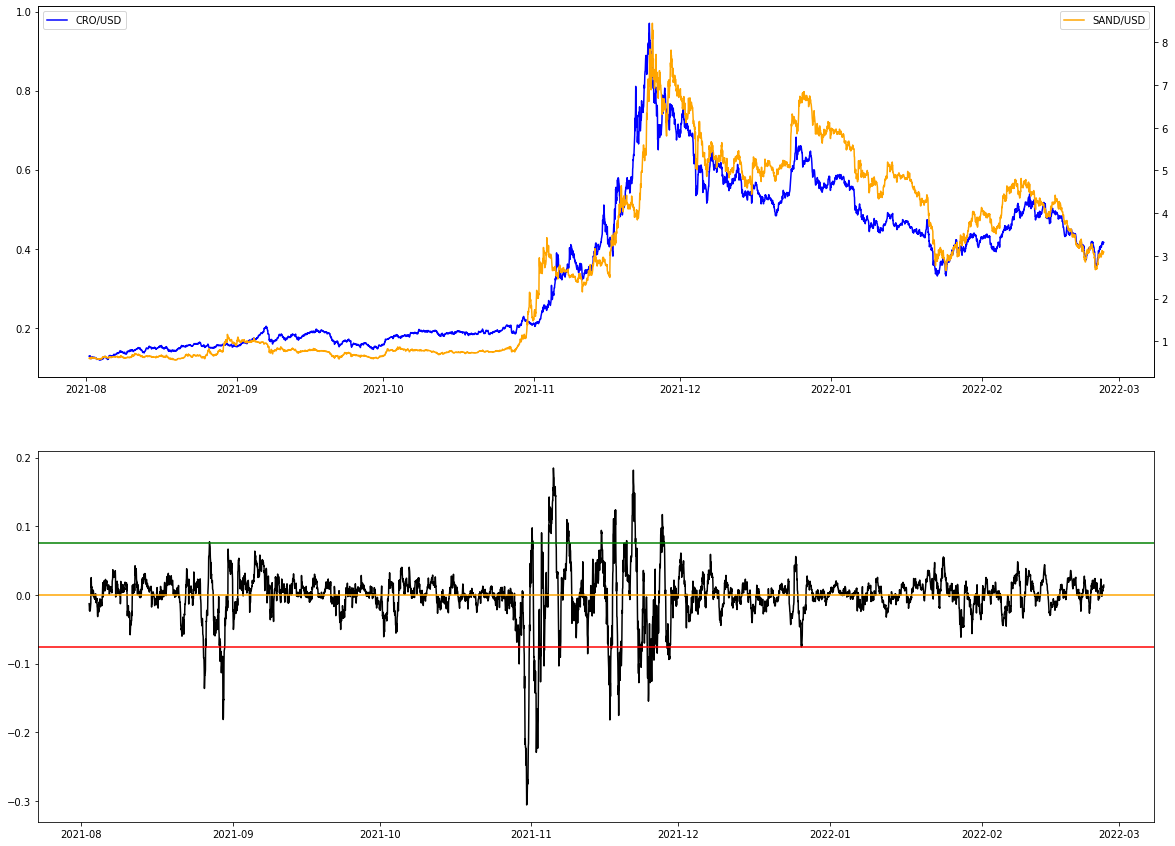

In [ ]:
get_pair_informations("CRO/USD", "SAND/USD")

Correlation = 95.54 %
Co-integration = 0.17469


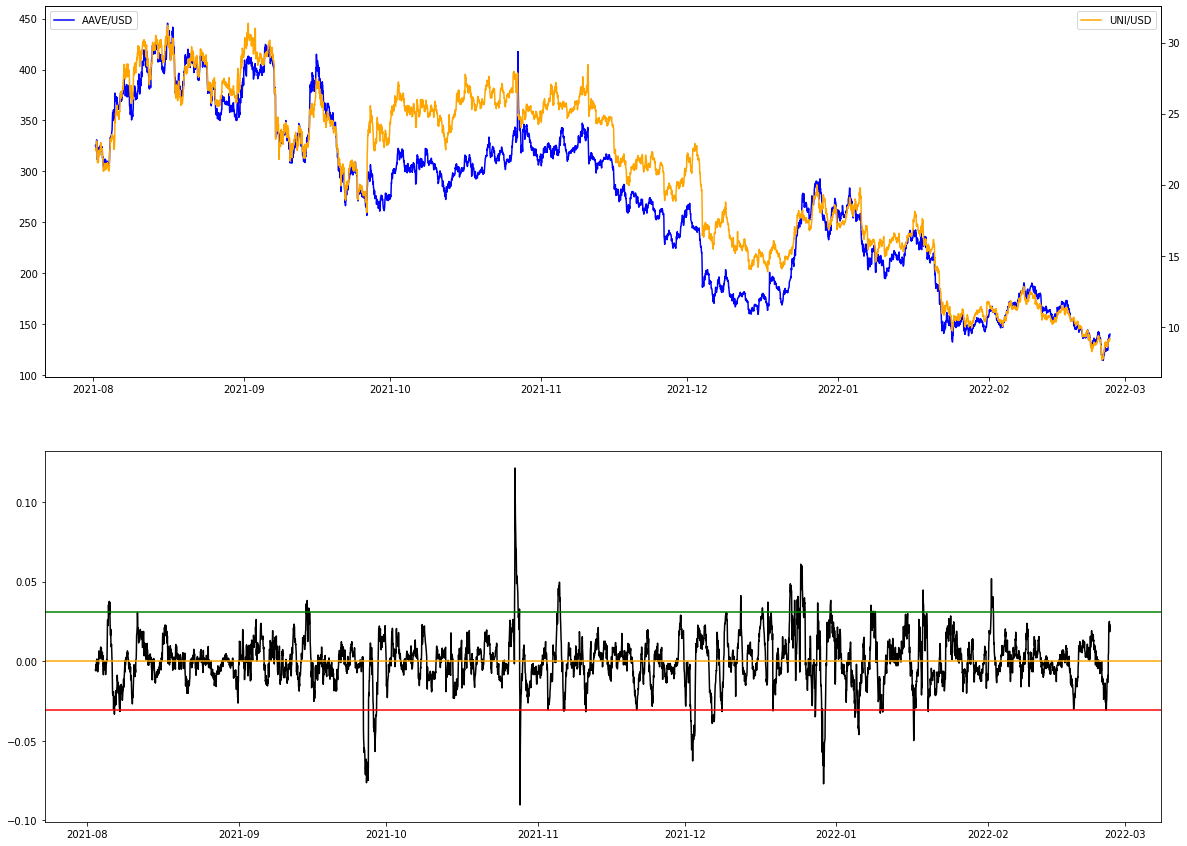

In [ ]:
get_pair_informations("AAVE/USD", "UNI/USD")

Correlation = 89.35 %
Co-integration = 0.02497


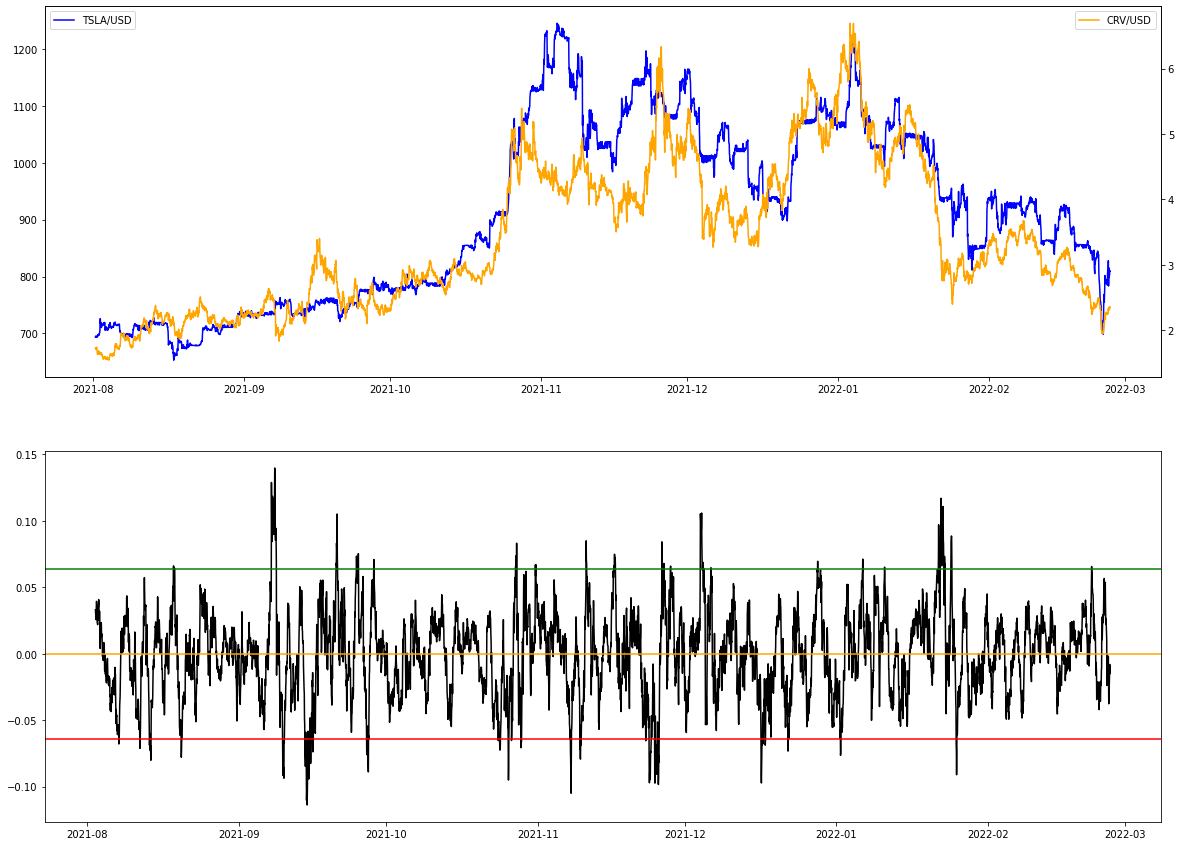

In [ ]:
get_pair_informations("TSLA/USD", "CRV/USD")

Correlation = 95.71 %
Co-integration = 0.37695


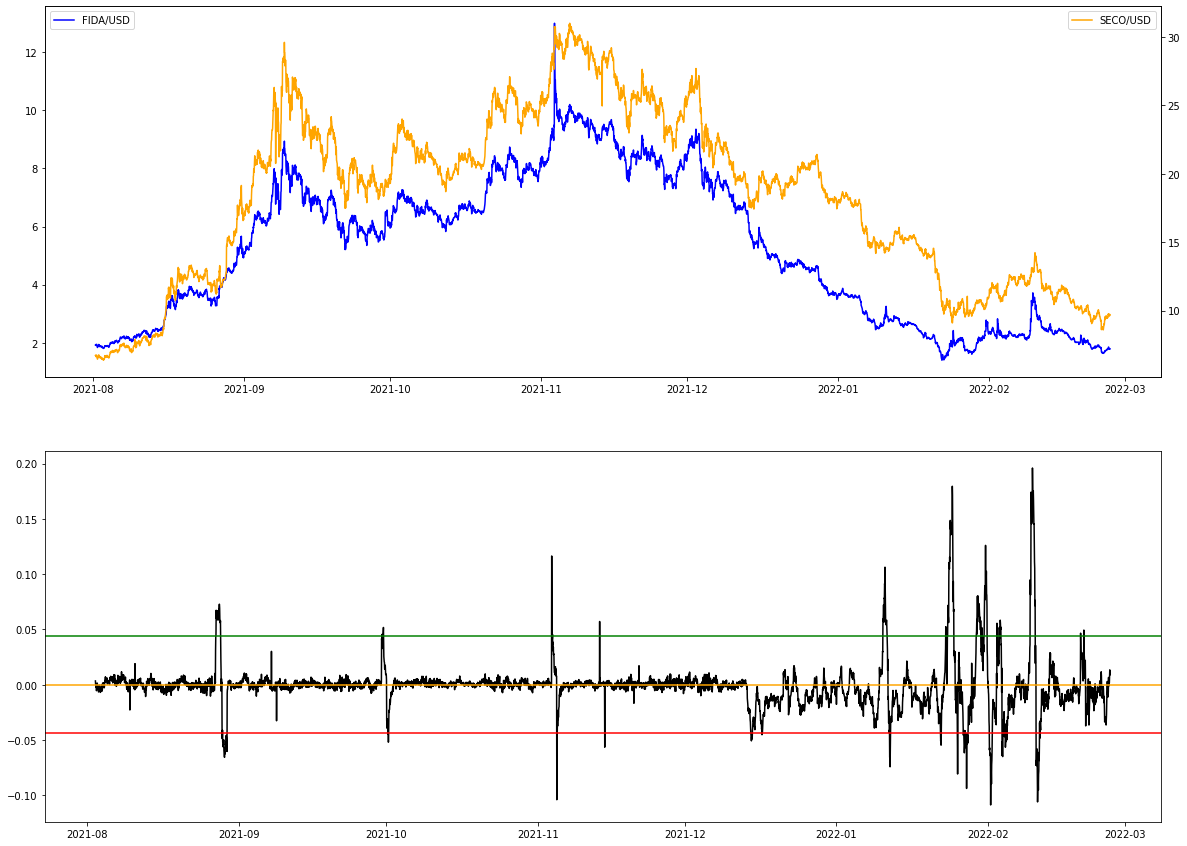

In [ ]:
get_pair_informations("FIDA/USD", "SECO/USD")

Correlation = -9.83 %
Co-integration = 0.0


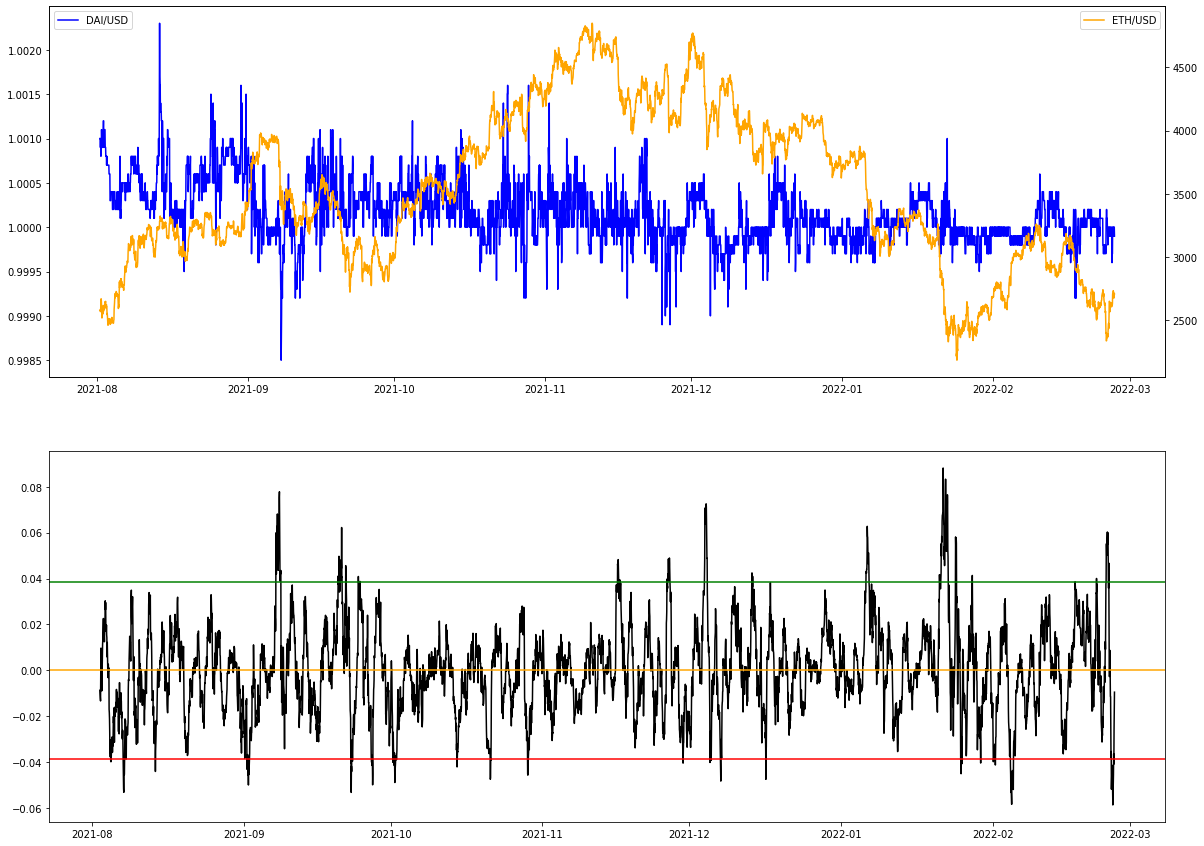

In [ ]:
get_pair_informations("DAI/USD", "ETH/USD")

Correlation = 100.0 %
Co-integration = 0.0


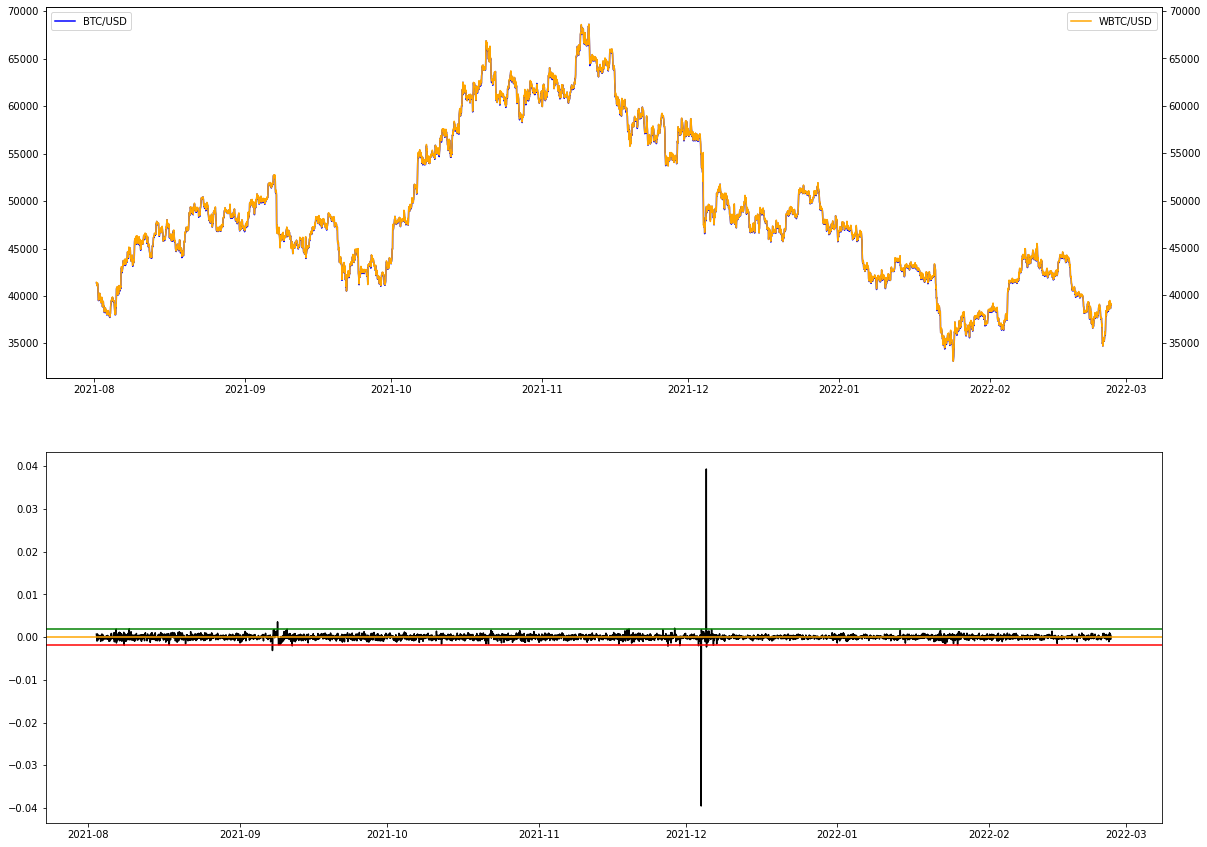

In [ ]:
get_pair_informations("BTC/USD", "WBTC/USD")